In [1]:
from pathlib import Path
import shutil
import os

# Creat work dir

In [2]:
!mkdir data

!mkdir data/train
!mkdir data/test

!mkdir data/train/beneign
!mkdir data/train/malignant
!mkdir data/train/normal

!mkdir data/test/beneign
!mkdir data/test/malignant
!mkdir data/test/normal

train_beneign_path = Path("bioverse-hackathon-a/train/beneign")
train_beneign_path = sorted(list(map(str, list(train_beneign_path.glob("*/*.png")))))
val_beneign_path = train_beneign_path[-28:]
train_beneign_path = train_beneign_path[:-28]

train_malignant_path = Path("bioverse-hackathon-a/train/malignant")
train_malignant_path = sorted(list(map(str, list(train_malignant_path.glob("*/*.png")))))
val_malignant_path = train_beneign_path[-20:]
train_malignant_path = train_malignant_path[:-20]


train_normal_path = Path("bioverse-hackathon-a/train/normal")
train_normal_path = sorted(list(map(str, list(train_normal_path.glob("*/*.png")))))
val_normal_path = train_normal_path[-28:]
train_normal_path = train_normal_path[:-28]

train_b_path = "data/train/beneign"
train_m_path = "data/train/malignant"
train_n_path = "data/train/normal"

val_b_path = "data/test/beneign"
val_m_path = "data/test/malignant"
val_n_path = "data/test/normal"

counter = 0
for img in train_beneign_path:
    shutil.copy(img, f"{train_b_path}/b_{counter}.png")
    counter += 1 
counter = 0
for img in val_beneign_path:
    shutil.copy(img, f"{val_b_path}/b_{counter}.png")
    counter += 1
    
counter = 0
for img in train_malignant_path:
    shutil.copy(img, f"{train_m_path}/m_{counter}.png")
    counter += 1
counter = 0
for img in val_malignant_path:
    shutil.copy(img, f"{val_m_path}/m_{counter}.png")
    counter += 1
    
counter = 0
for img in train_normal_path:
    shutil.copy(img, f"{train_n_path}/n_{counter}.png")
    counter += 1
counter = 0
for img in val_normal_path:
    shutil.copy(img, f"{val_n_path}/n_{counter}.png")
    counter += 1

/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mostafatarek/anaconda3/lib/libtinfo.so.6: no version in

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

# Taining pipline

In [4]:
INPUT_HEIGHT = INPUT_WIDTH = 224
train_path = "data/train"
val_path = "data/test"

N_WAY = 3 # Number of classes in a task
N_SHOT = 10 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

N_TRAINING_EPISODES = 500
N_VALIDATION_TASKS = 100


In [5]:
resize = transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH)) #Resize
vFlip = transforms.RandomVerticalFlip(p=0.25) #Vertical Flip
rotate = transforms.RandomRotation(degrees=15) # RandomRotation
trainTransforms = transforms.Compose([resize, vFlip, rotate, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

In [6]:
trainDataset = ImageFolder(root=train_path, transform=trainTransforms)
valDataset = ImageFolder(root=val_path,  transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

[INFO] training dataset contains 300 samples...
[INFO] validation dataset contains 76 samples...


In [7]:
trainDataset.get_labels = lambda: [instance[1] for instance in trainDataset.imgs]
valDataset.get_labels = lambda: [instance[1] for instance in valDataset.imgs]

In [8]:
# Import necessary modules
from torch.utils.data import DataLoader

# Define a TaskSampler for training data
train_sampler = TaskSampler(
    trainDataset,  # Training dataset
    n_way=N_WAY,   # Number of classes per task
    n_shot=N_SHOT,  # Number of support examples per class
    n_query=N_QUERY,  # Number of query examples per class
    n_tasks=N_TRAINING_EPISODES  # Number of training episodes (tasks)
)

# Create a DataLoader for training data using the TaskSampler
train_loader = DataLoader(
    trainDataset,  # Training dataset
    batch_sampler=train_sampler,  # Use the defined TaskSampler
    num_workers=2,  # Number of worker processes for data loading
    pin_memory=True,  # Pin memory for faster GPU transfers
    collate_fn=train_sampler.episodic_collate_fn  # Collate function for episodic data
)

# Define a TaskSampler for testing (validation) data
test_sampler = TaskSampler(
    valDataset,  # Validation dataset
    n_way=N_WAY,   # Number of classes per task
    n_shot=N_SHOT,  # Number of support examples per class
    n_query=N_QUERY,  # Number of query examples per class
    n_tasks=N_EVALUATION_TASKS  # Number of evaluation tasks
)

# Create a DataLoader for testing (validation) data using the TaskSampler
test_loader = DataLoader(
    valDataset,  # Validation dataset
    batch_sampler=test_sampler,  # Use the defined TaskSampler
    num_workers=2,  # Number of worker processes for data loading
    pin_memory=True,  # Pin memory for faster GPU transfers
    collate_fn=test_sampler.episodic_collate_fn,  # Collate function for episodic data
)


In [9]:
# Import necessary libraries
from torchvision.models import convnext_tiny
from torchvision.models import ConvNeXt_Tiny_Weights

# Import required modules from PyTorch
import torch
import torch.nn as nn

# Define a class for the Prototypical Networks
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Forward pass of the Prototypical Networks.
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images using the provided backbone
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes (ways) from the labels of the support set
        n_way = len(torch.unique(support_labels))
        
        # Calculate prototypes for each class by taking the mean of support features with the same label
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the Euclidean distance from query features to prototypes
        dists = torch.cdist(z_query, z_proto)

        # Calculate classification scores based on the negative of distances
        scores = -dists
        return scores

# Load a pre-trained ResNet18 model as the backbone for feature extraction
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()  # Replace the fully connected layer with a flattening operation
print(convolutional_network)

# Create an instance of the PrototypicalNetworks model using the provided backbone
model = PrototypicalNetworks(convolutional_network).cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/mostafatarek/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mostafatarek/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Import necessary modules
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0015)

# Define the 'fit' function for training
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    # Reset gradients in the optimizer
    optimizer.zero_grad()

    # Forward pass through the model
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    # Calculate the loss using the specified loss function
    loss = criterion(classification_scores, query_labels.cuda())
    
    # Backpropagate the gradients
    loss.backward()
    
    # Update the model's parameters using the optimizer
    optimizer.step()

    # Return the loss value as a floating-point number
    return loss.item()


In [11]:
# Set the frequency for logging updates
log_update_frequency = 10

# Initialize an empty list to store loss values
all_loss = []

# Set the model in training mode
model.train()

# Use tqdm to create a progress bar over the training loader
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    # Iterate through training episodes
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        # Calculate the loss and perform optimization through the 'fit' function
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        
        # Append the loss value to the list
        all_loss.append(loss_value)

        # Log the loss at the specified frequency
        if episode_index % log_update_frequency == 0:
            # Calculate a sliding average of the loss values
            sliding_avg_loss = sliding_average(all_loss, log_update_frequency)
            
            # Update the tqdm progress bar with the current loss
            tqdm_train.set_postfix(loss=sliding_avg_loss)


100%|██████████| 500/500 [15:32<00:00,  1.87s/it, loss=0.345]


  0%|          | 0/100 [00:00<?, ?it/s]

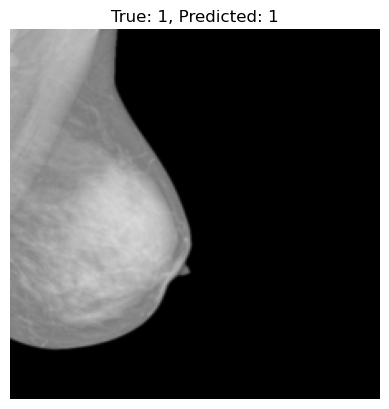

  1%|          | 1/100 [00:04<06:53,  4.17s/it]

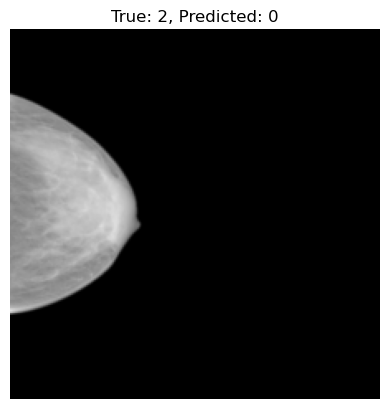

  2%|▏         | 2/100 [00:04<03:00,  1.84s/it]

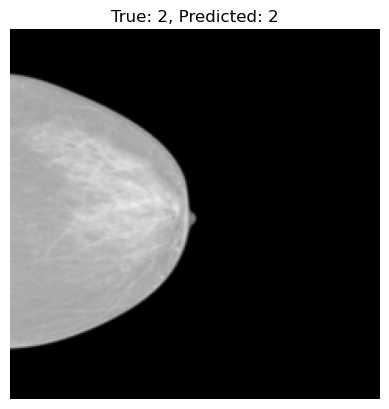

  3%|▎         | 3/100 [00:08<04:17,  2.66s/it]

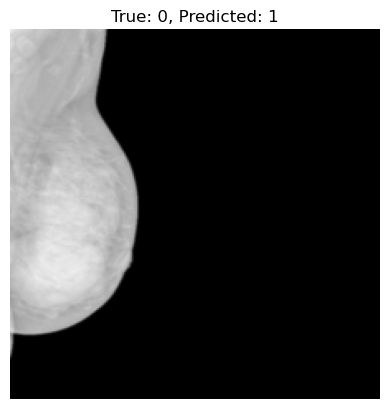

  4%|▍         | 4/100 [00:08<02:41,  1.68s/it]

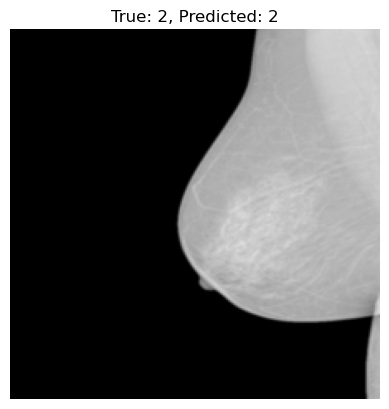

  5%|▌         | 5/100 [00:11<03:40,  2.32s/it]

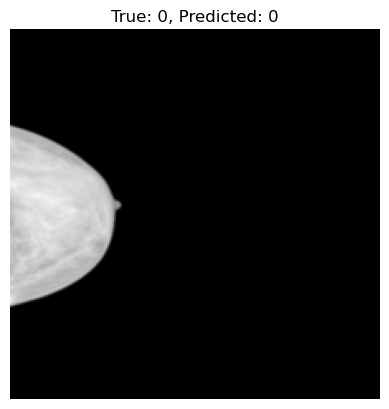

  6%|▌         | 6/100 [00:11<02:30,  1.60s/it]

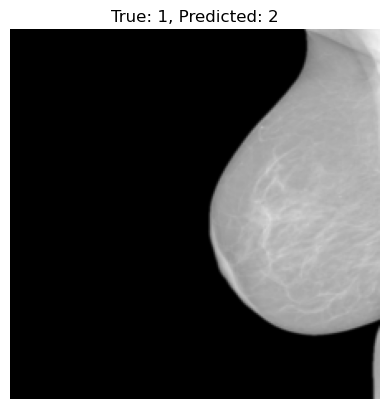

  7%|▋         | 7/100 [00:15<03:27,  2.23s/it]

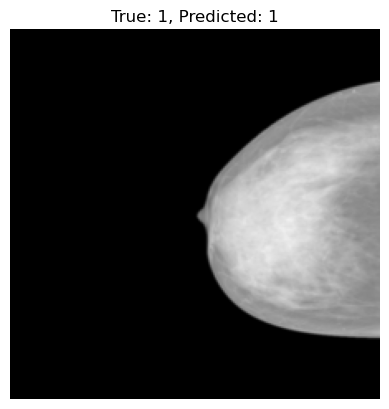

  8%|▊         | 8/100 [00:15<02:25,  1.58s/it]

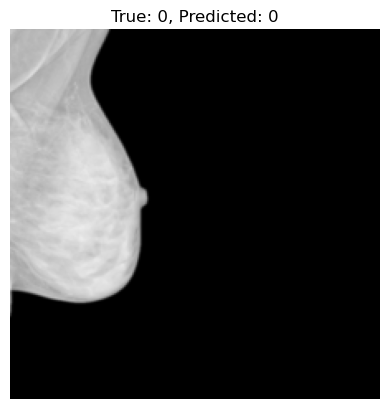

  9%|▉         | 9/100 [00:19<03:18,  2.18s/it]

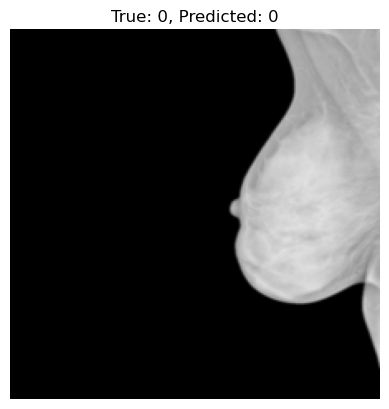

 10%|█         | 10/100 [00:19<02:21,  1.57s/it]

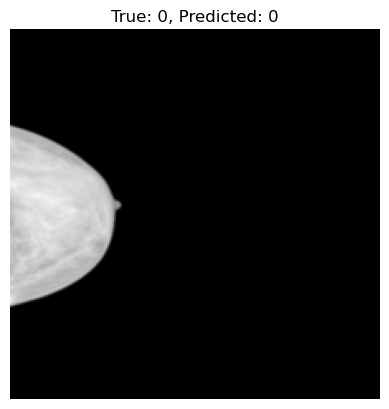

 11%|█         | 11/100 [00:22<03:11,  2.15s/it]

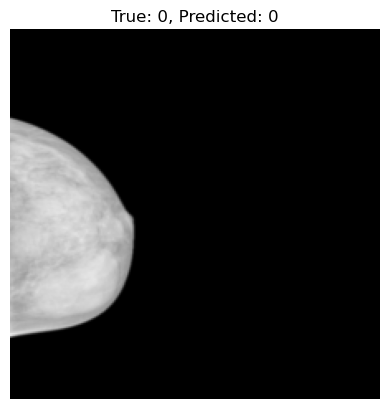

 12%|█▏        | 12/100 [00:22<02:18,  1.57s/it]

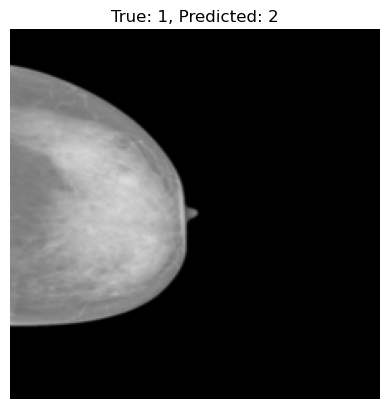

 13%|█▎        | 13/100 [00:26<03:08,  2.16s/it]

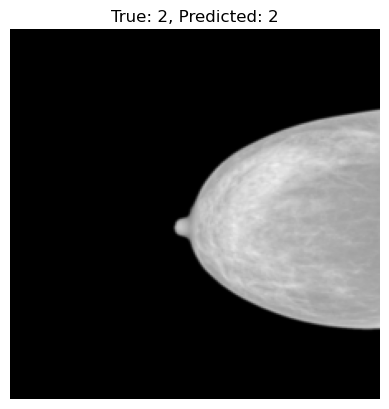

 14%|█▍        | 14/100 [00:26<02:14,  1.56s/it]

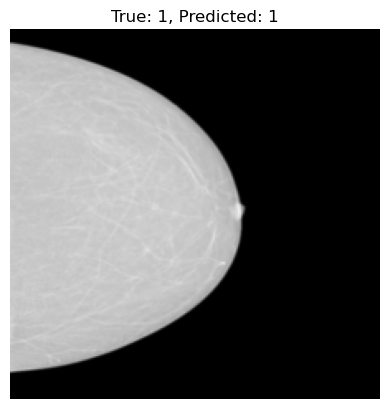

 15%|█▌        | 15/100 [00:30<03:00,  2.12s/it]

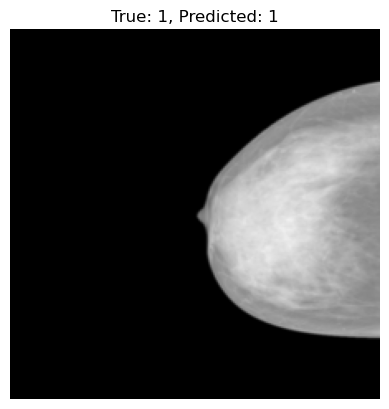

 16%|█▌        | 16/100 [00:30<02:11,  1.57s/it]

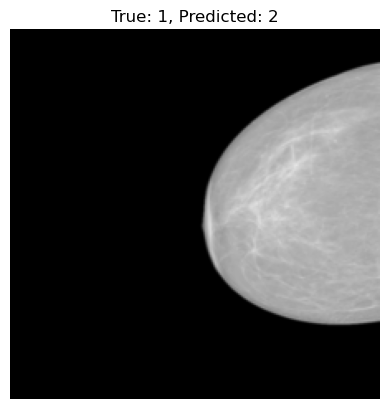

 17%|█▋        | 17/100 [00:33<02:53,  2.09s/it]

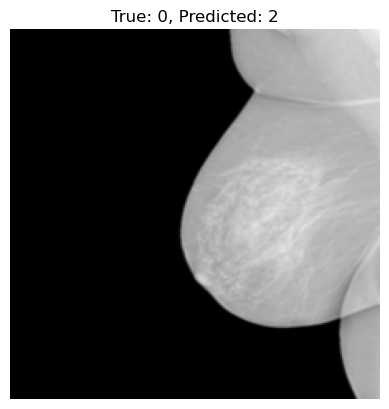

 18%|█▊        | 18/100 [00:33<02:06,  1.55s/it]

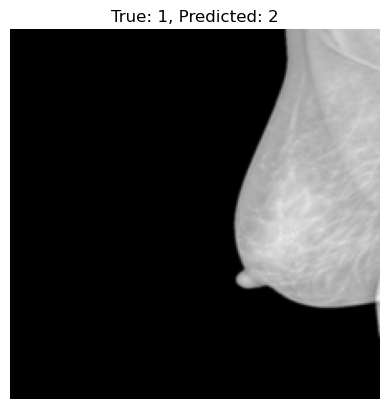

 19%|█▉        | 19/100 [00:37<02:47,  2.07s/it]

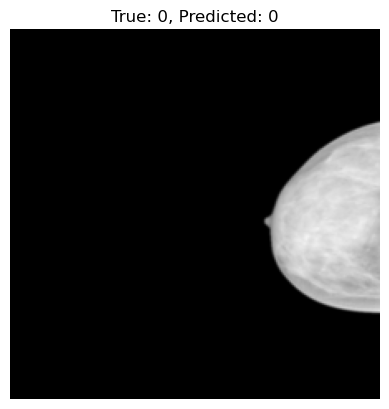

 20%|██        | 20/100 [00:37<02:02,  1.53s/it]

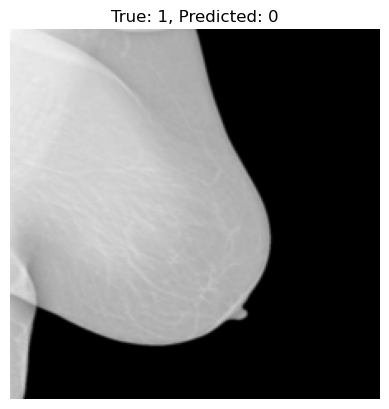

 21%|██        | 21/100 [00:40<02:43,  2.06s/it]

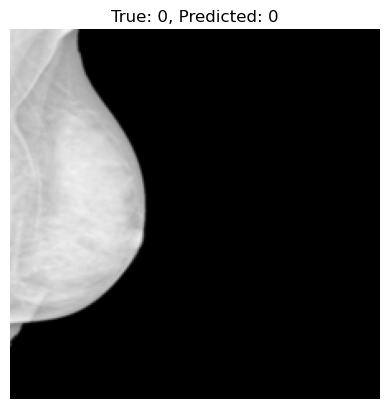

 22%|██▏       | 22/100 [00:41<01:58,  1.52s/it]

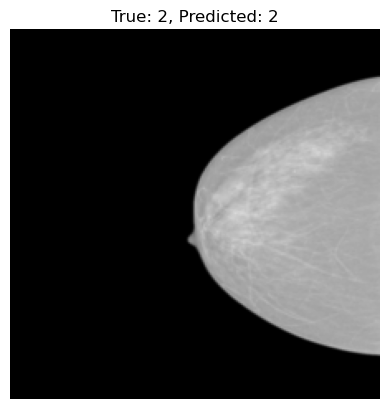

 23%|██▎       | 23/100 [00:44<02:37,  2.05s/it]

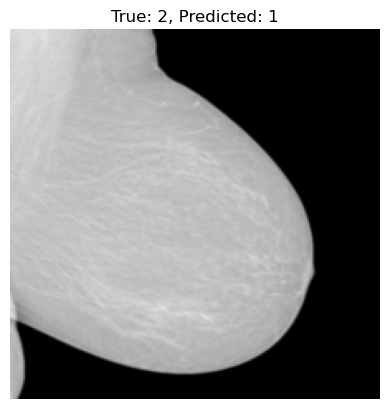

 24%|██▍       | 24/100 [00:44<01:56,  1.53s/it]

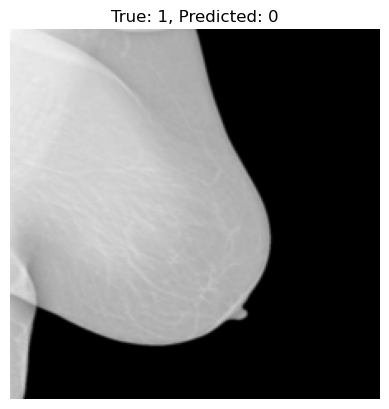

 25%|██▌       | 25/100 [00:48<02:35,  2.08s/it]

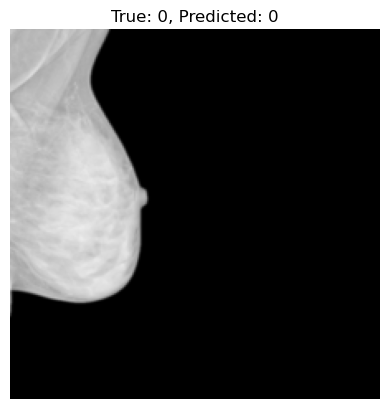

 26%|██▌       | 26/100 [00:48<01:55,  1.56s/it]

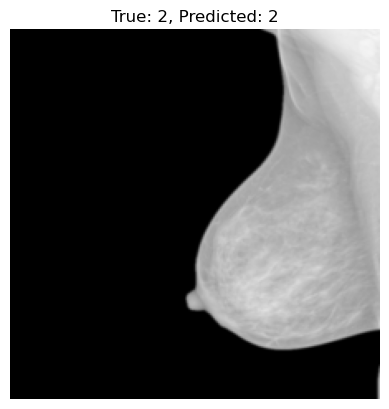

 27%|██▋       | 27/100 [00:51<02:33,  2.10s/it]

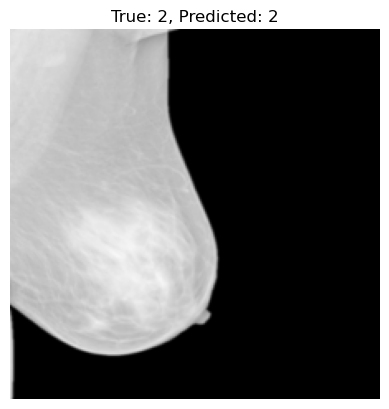

 28%|██▊       | 28/100 [00:52<01:55,  1.60s/it]

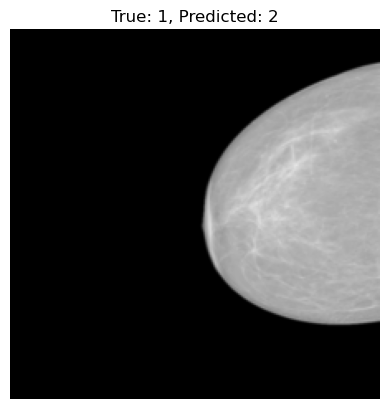

 29%|██▉       | 29/100 [00:55<02:32,  2.15s/it]

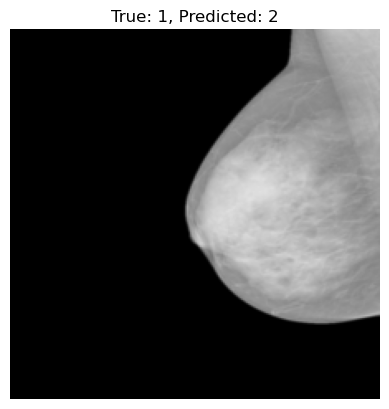

 30%|███       | 30/100 [00:55<01:52,  1.61s/it]

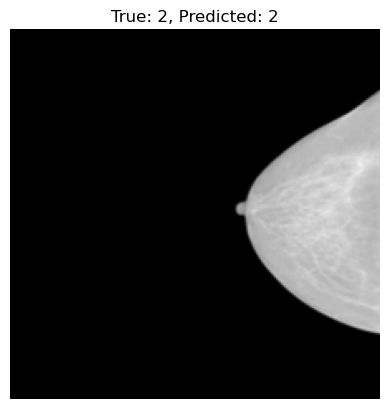

 31%|███       | 31/100 [00:59<02:27,  2.14s/it]

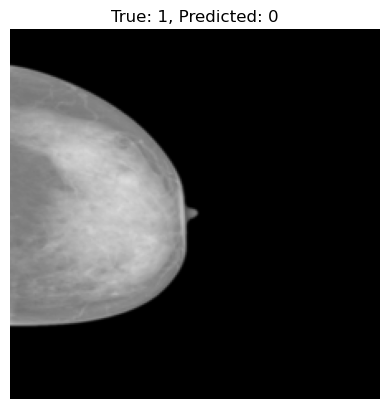

 32%|███▏      | 32/100 [00:59<01:49,  1.61s/it]

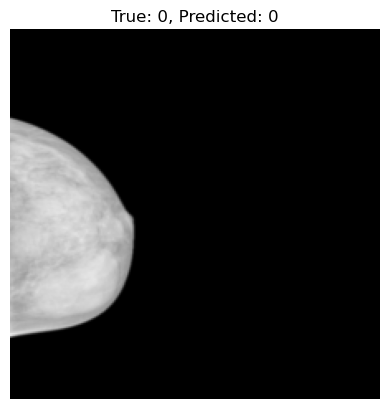

 33%|███▎      | 33/100 [01:03<02:23,  2.14s/it]

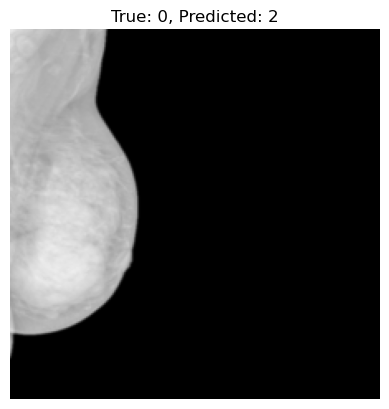

 34%|███▍      | 34/100 [01:03<01:46,  1.61s/it]

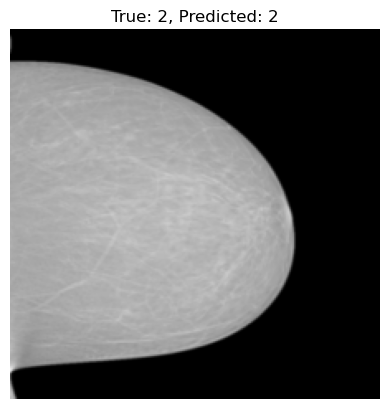

 35%|███▌      | 35/100 [01:06<02:17,  2.12s/it]

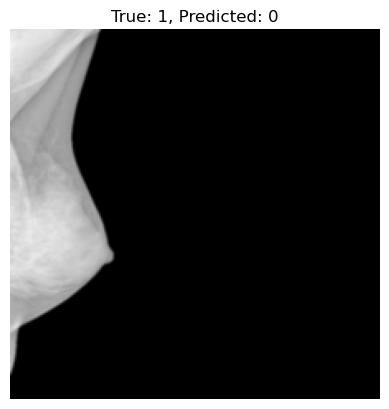

 36%|███▌      | 36/100 [01:07<01:42,  1.60s/it]

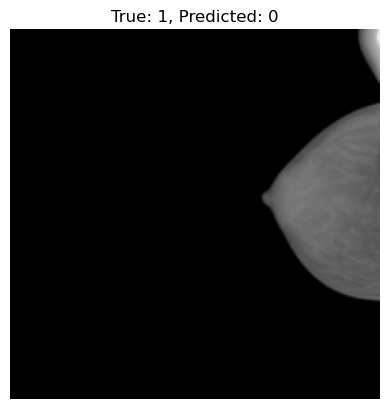

 37%|███▋      | 37/100 [01:10<02:13,  2.12s/it]

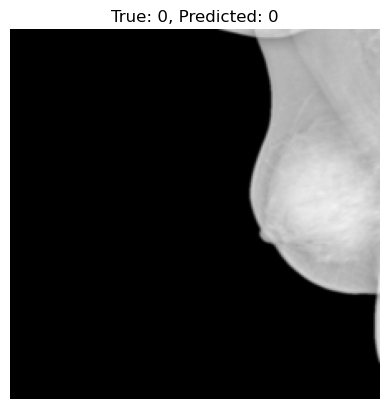

 38%|███▊      | 38/100 [01:10<01:39,  1.60s/it]

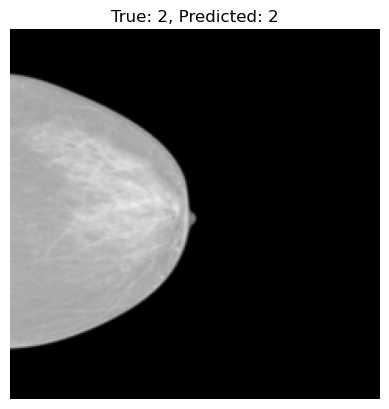

 39%|███▉      | 39/100 [01:14<02:08,  2.11s/it]

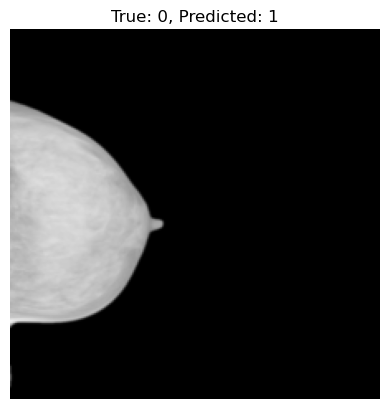

 40%|████      | 40/100 [01:14<01:34,  1.58s/it]

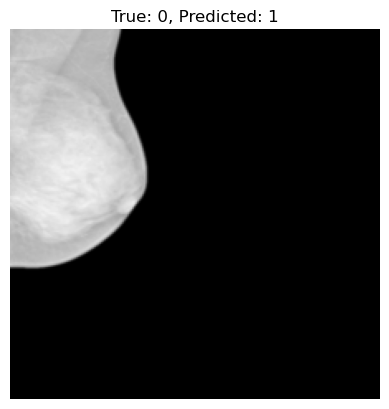

 41%|████      | 41/100 [01:17<02:03,  2.10s/it]

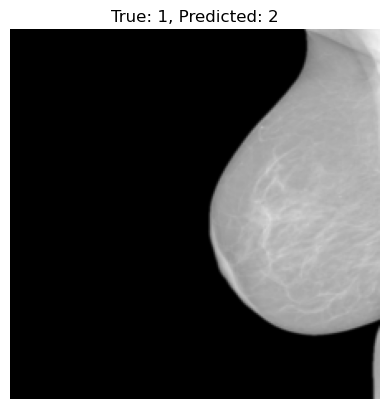

 42%|████▏     | 42/100 [01:18<01:32,  1.59s/it]

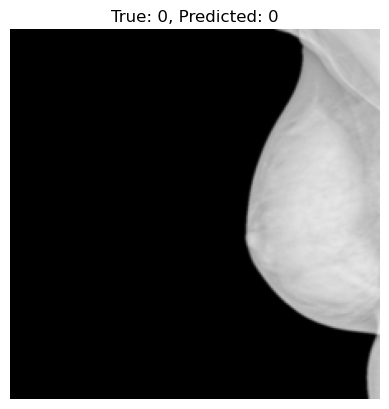

 43%|████▎     | 43/100 [01:21<01:59,  2.09s/it]

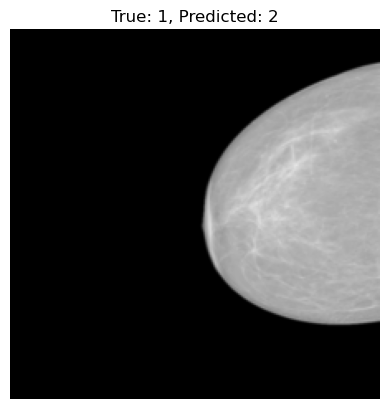

 44%|████▍     | 44/100 [01:21<01:29,  1.59s/it]

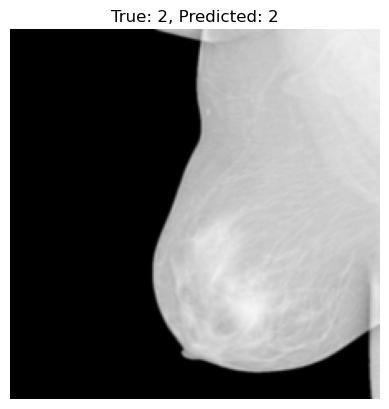

 45%|████▌     | 45/100 [01:25<01:54,  2.09s/it]

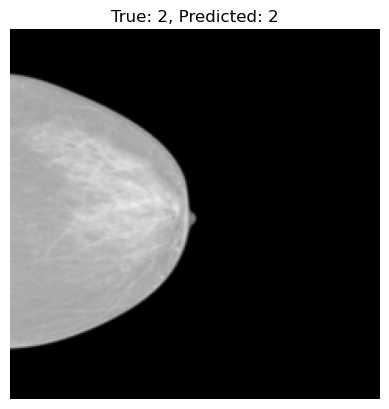

 46%|████▌     | 46/100 [01:25<01:26,  1.60s/it]

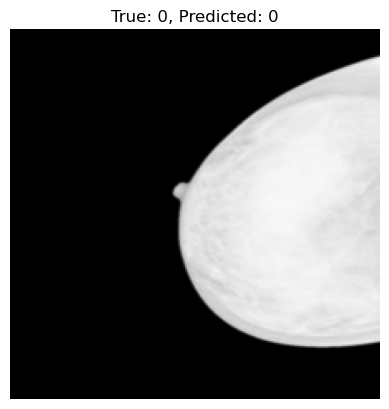

 47%|████▋     | 47/100 [01:28<01:51,  2.10s/it]

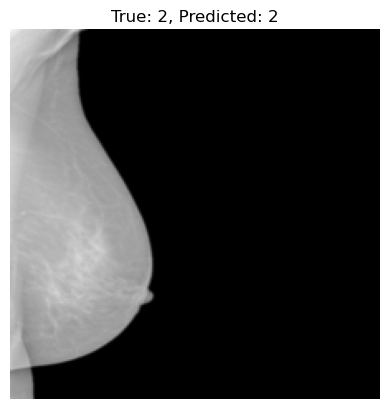

 48%|████▊     | 48/100 [01:29<01:24,  1.62s/it]

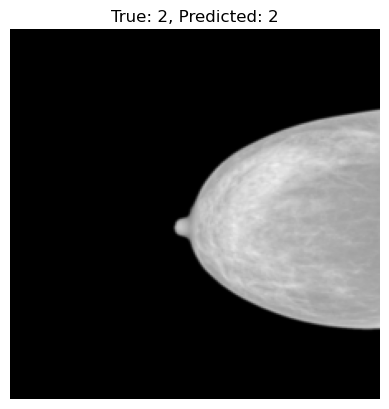

 49%|████▉     | 49/100 [01:32<01:46,  2.08s/it]

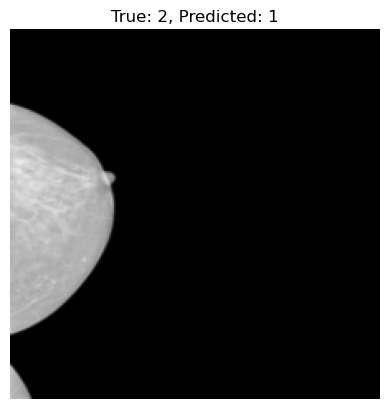

 50%|█████     | 50/100 [01:33<01:21,  1.63s/it]

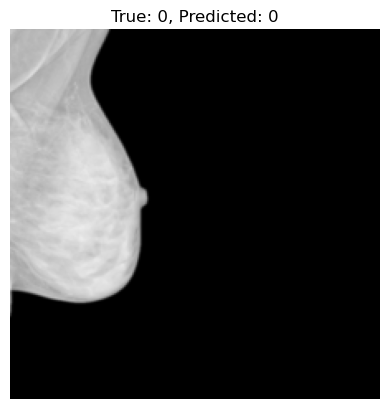

 51%|█████     | 51/100 [01:36<01:41,  2.07s/it]

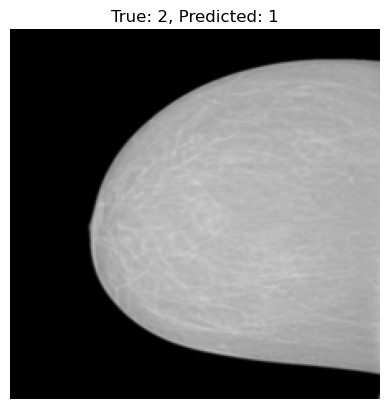

 52%|█████▏    | 52/100 [01:36<01:18,  1.63s/it]

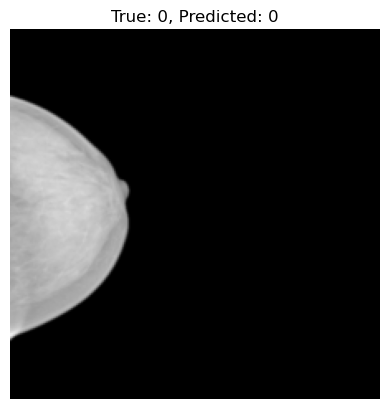

 53%|█████▎    | 53/100 [01:39<01:34,  2.02s/it]

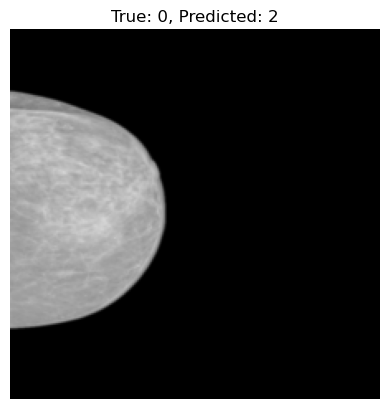

 54%|█████▍    | 54/100 [01:40<01:14,  1.62s/it]

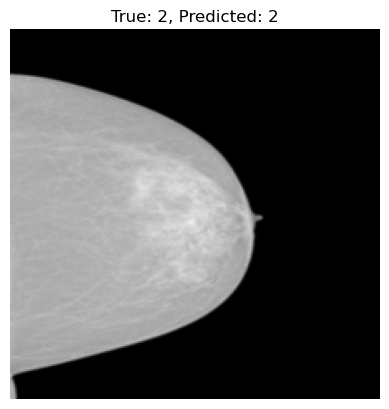

 55%|█████▌    | 55/100 [01:43<01:31,  2.04s/it]

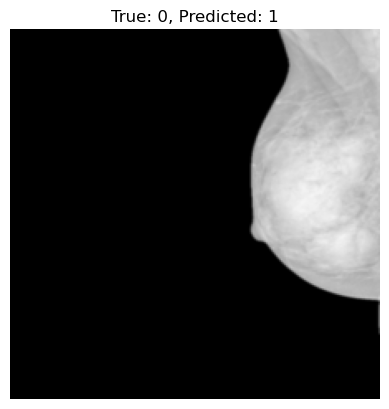

 56%|█████▌    | 56/100 [01:44<01:10,  1.59s/it]

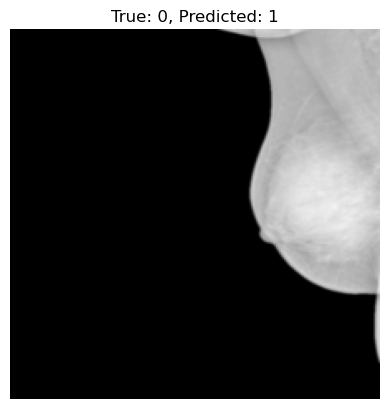

 57%|█████▋    | 57/100 [01:46<01:25,  1.99s/it]

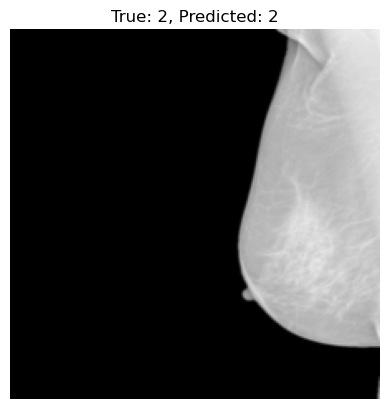

 58%|█████▊    | 58/100 [01:47<01:07,  1.62s/it]

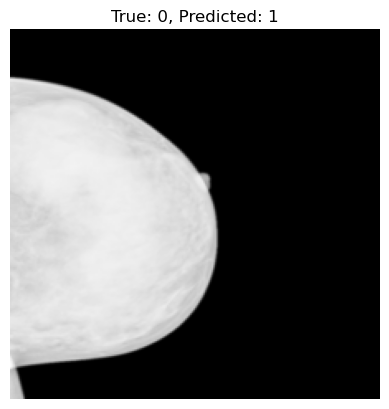

 59%|█████▉    | 59/100 [01:50<01:20,  1.97s/it]

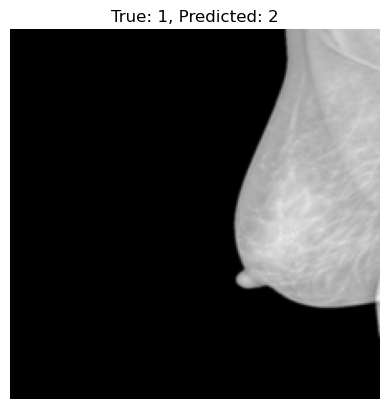

 60%|██████    | 60/100 [01:51<01:05,  1.63s/it]

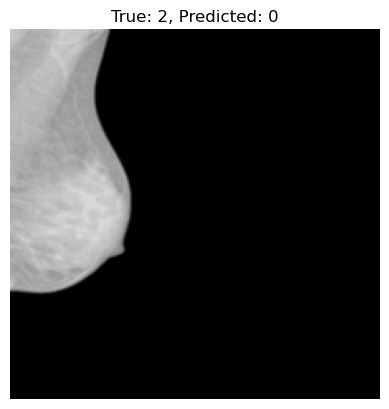

 61%|██████    | 61/100 [01:54<01:17,  1.99s/it]

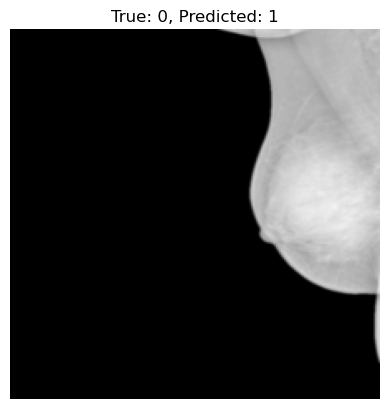

 62%|██████▏   | 62/100 [01:55<01:03,  1.67s/it]

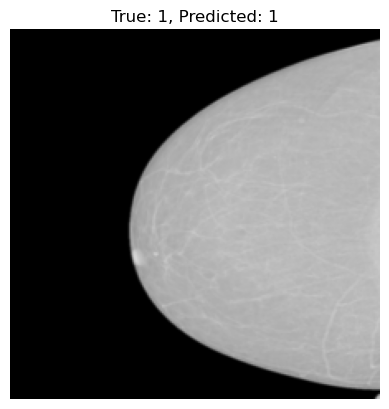

 63%|██████▎   | 63/100 [01:57<01:14,  2.01s/it]

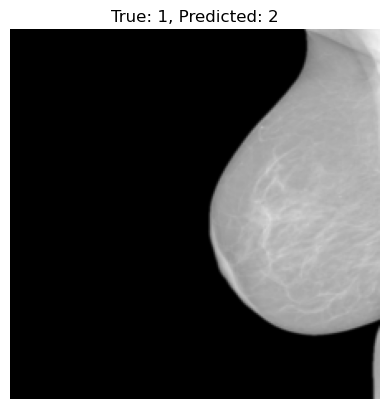

 64%|██████▍   | 64/100 [01:58<01:00,  1.68s/it]

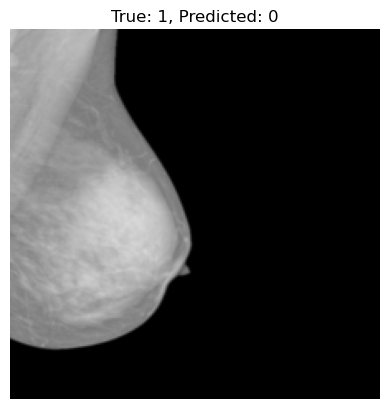

 65%|██████▌   | 65/100 [02:01<01:10,  2.01s/it]

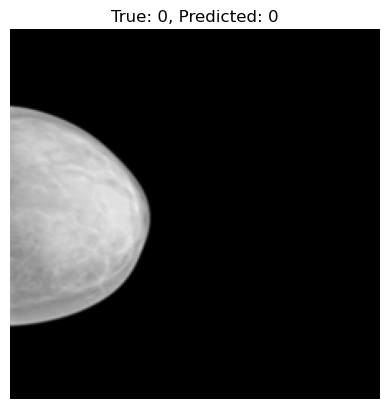

 66%|██████▌   | 66/100 [02:02<00:56,  1.68s/it]

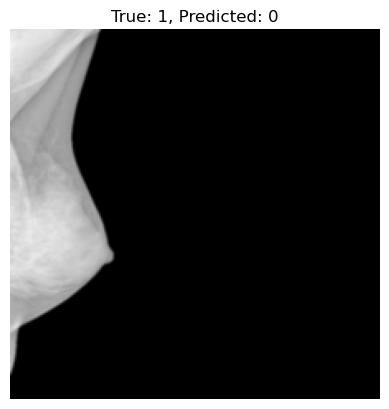

 67%|██████▋   | 67/100 [02:05<01:06,  2.03s/it]

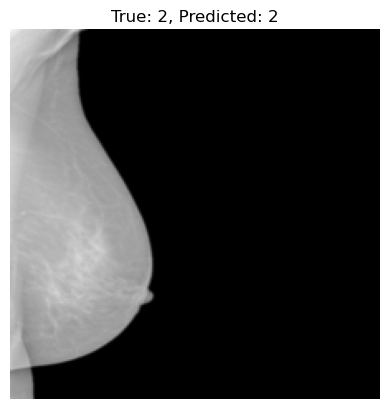

 68%|██████▊   | 68/100 [02:06<00:53,  1.68s/it]

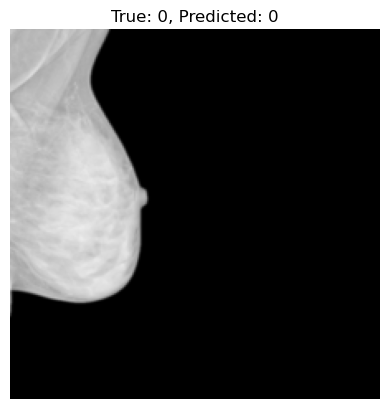

 69%|██████▉   | 69/100 [02:09<01:03,  2.05s/it]

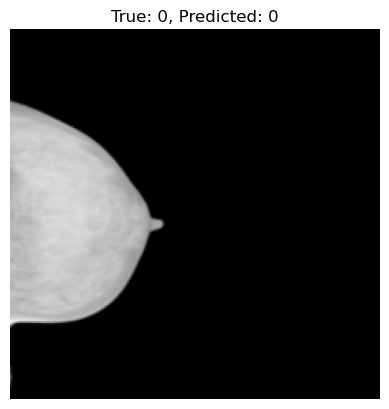

 70%|███████   | 70/100 [02:09<00:51,  1.70s/it]

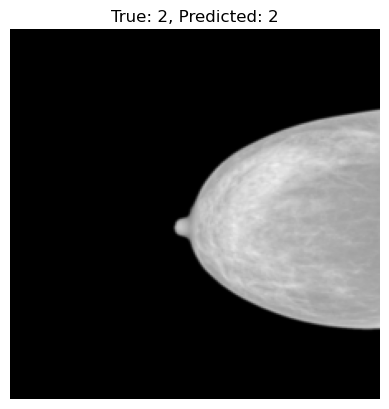

 71%|███████   | 71/100 [02:12<00:58,  2.03s/it]

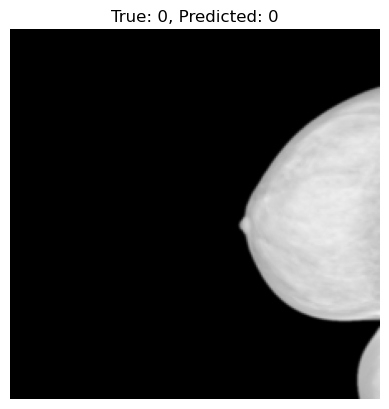

 72%|███████▏  | 72/100 [02:13<00:47,  1.71s/it]

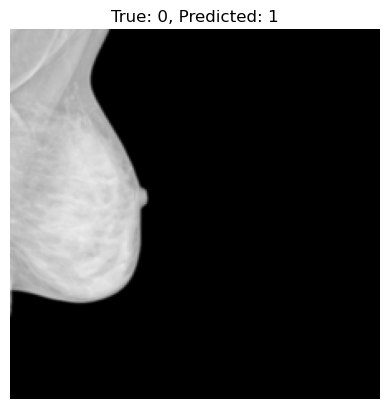

 73%|███████▎  | 73/100 [02:16<00:54,  2.03s/it]

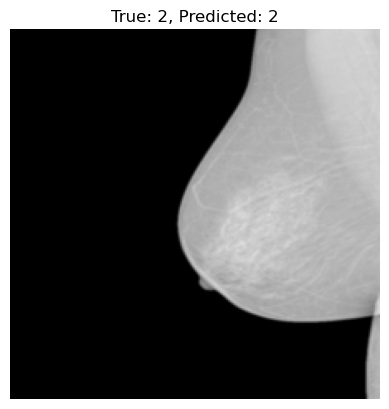

 74%|███████▍  | 74/100 [02:17<00:44,  1.72s/it]

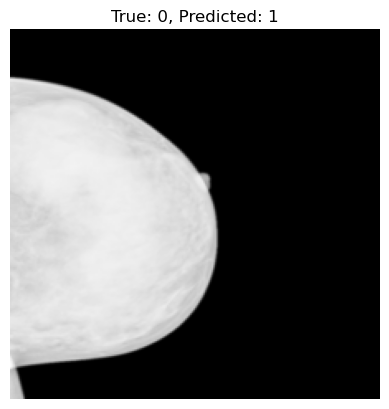

 75%|███████▌  | 75/100 [02:20<00:50,  2.04s/it]

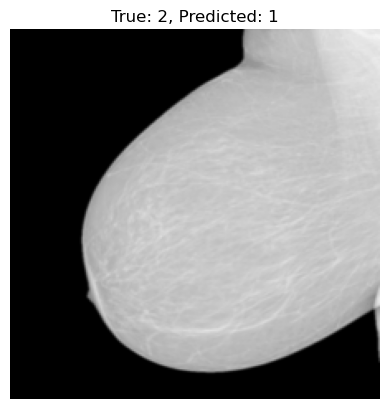

 76%|███████▌  | 76/100 [02:21<00:42,  1.76s/it]

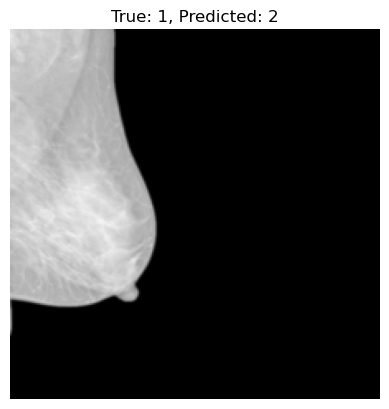

 77%|███████▋  | 77/100 [02:24<00:46,  2.01s/it]

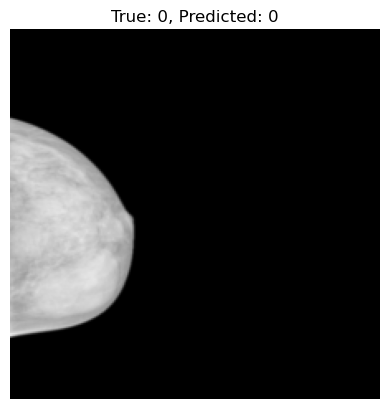

 78%|███████▊  | 78/100 [02:25<00:38,  1.74s/it]

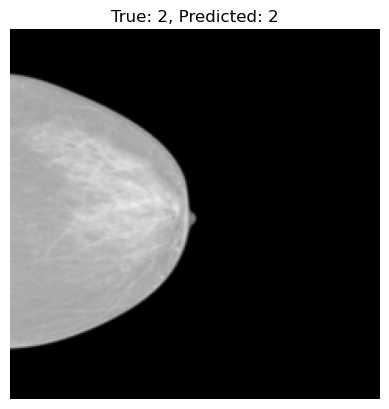

 79%|███████▉  | 79/100 [02:27<00:41,  1.99s/it]

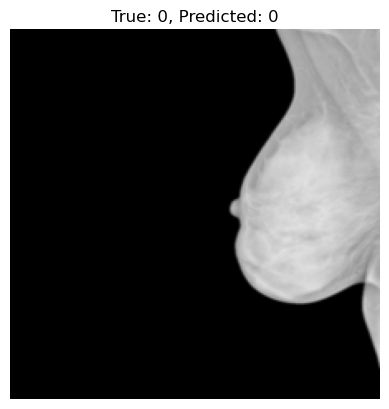

 80%|████████  | 80/100 [02:28<00:34,  1.75s/it]

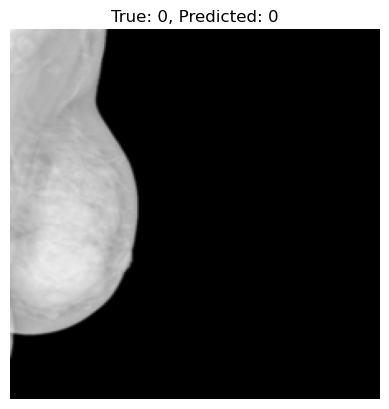

 81%|████████  | 81/100 [02:31<00:38,  2.01s/it]

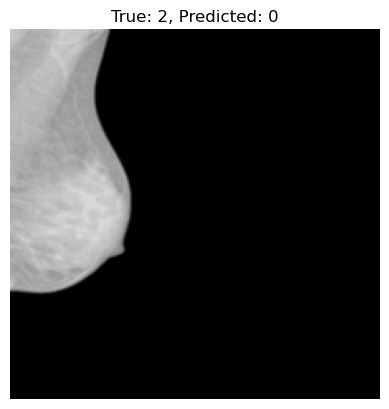

 82%|████████▏ | 82/100 [02:32<00:31,  1.77s/it]

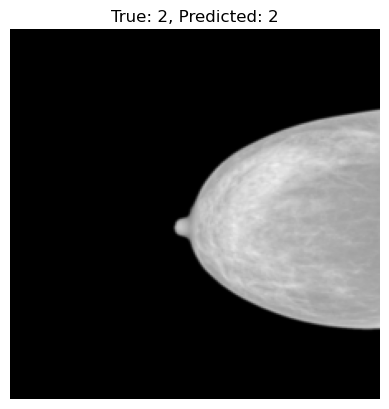

 83%|████████▎ | 83/100 [02:35<00:34,  2.02s/it]

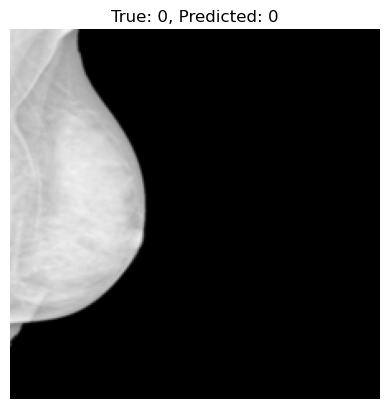

 84%|████████▍ | 84/100 [02:36<00:28,  1.79s/it]

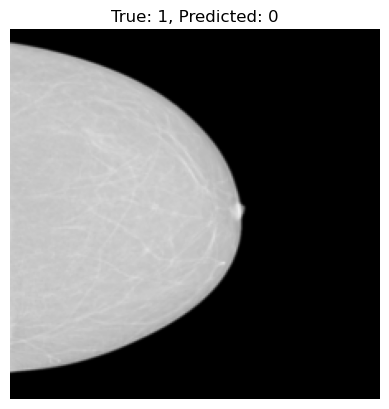

 85%|████████▌ | 85/100 [02:39<00:30,  2.01s/it]

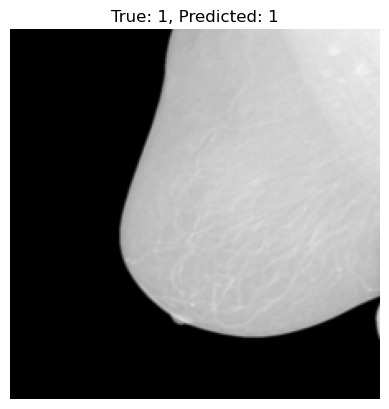

 86%|████████▌ | 86/100 [02:40<00:24,  1.77s/it]

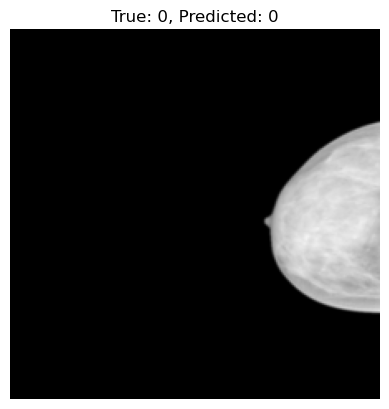

 87%|████████▋ | 87/100 [02:42<00:25,  1.99s/it]

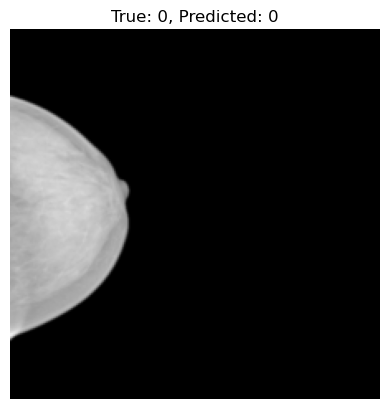

 88%|████████▊ | 88/100 [02:44<00:21,  1.76s/it]

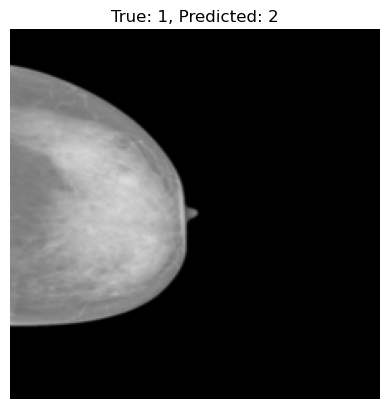

 89%|████████▉ | 89/100 [02:46<00:21,  1.96s/it]

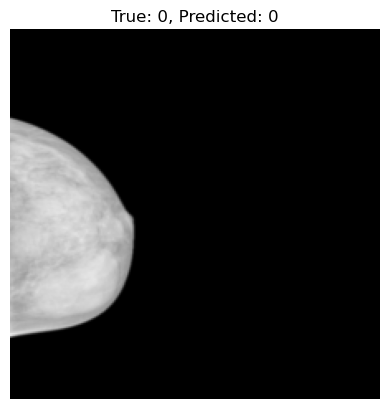

 90%|█████████ | 90/100 [02:47<00:17,  1.74s/it]

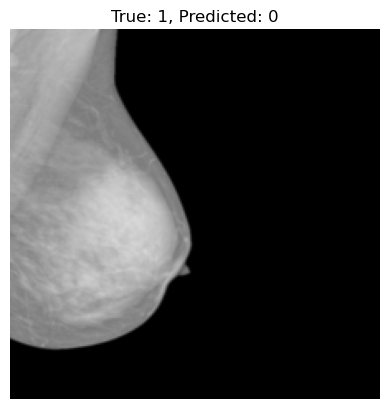

 91%|█████████ | 91/100 [02:50<00:17,  1.99s/it]

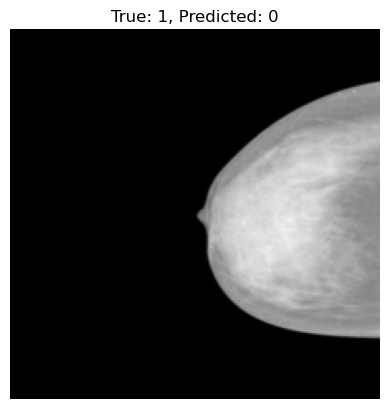

 92%|█████████▏| 92/100 [02:51<00:14,  1.77s/it]

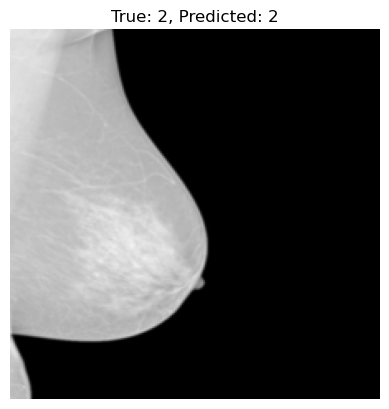

 93%|█████████▎| 93/100 [02:54<00:14,  2.01s/it]

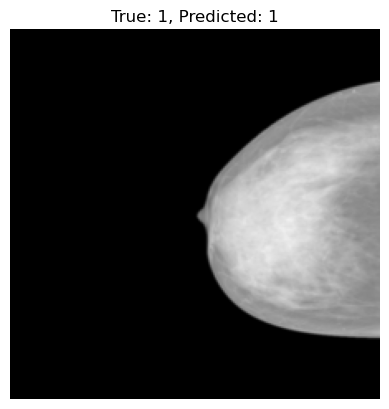

 94%|█████████▍| 94/100 [02:55<00:10,  1.79s/it]

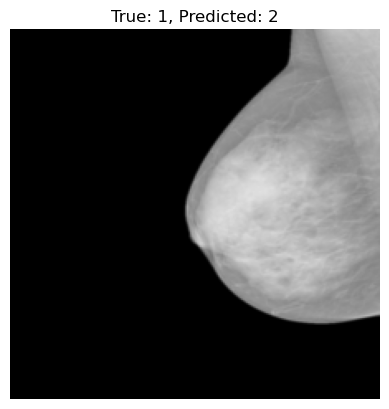

 95%|█████████▌| 95/100 [02:57<00:10,  2.00s/it]

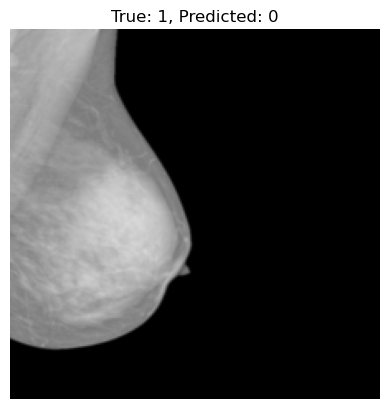

 96%|█████████▌| 96/100 [02:59<00:07,  1.78s/it]

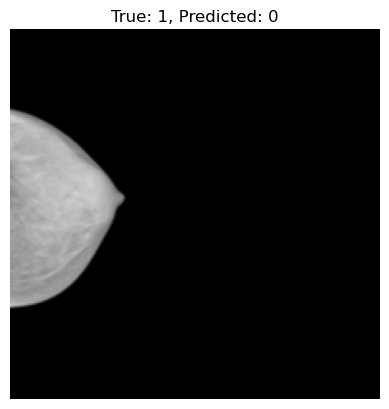

 97%|█████████▋| 97/100 [03:01<00:05,  1.97s/it]

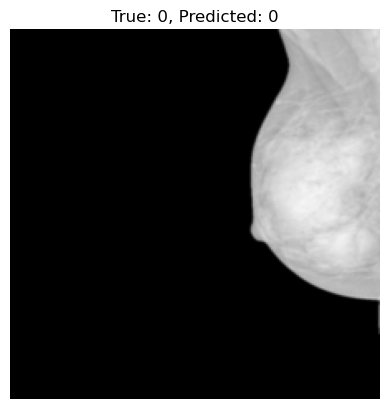

 98%|█████████▊| 98/100 [03:02<00:03,  1.76s/it]

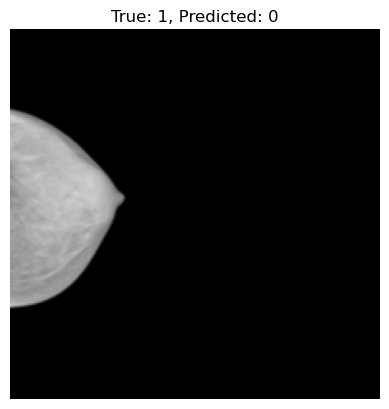

 99%|█████████▉| 99/100 [03:05<00:01,  1.95s/it]

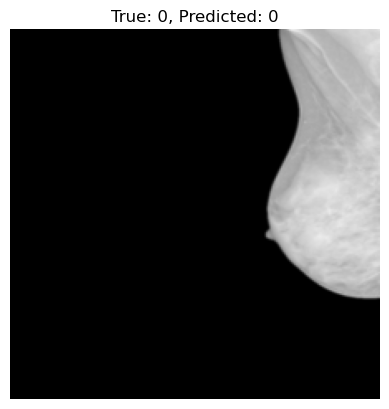

100%|██████████| 100/100 [03:06<00:00,  1.87s/it]

Model tested on 100 tasks.
Average F1 score: 0.4521
Average Accuracy: 47.43%


In [12]:
import matplotlib.pyplot as plt
from typing import List
from sklearn.metrics import f1_score, accuracy_score
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [float, float, List[int], List[int]]:
    """
    Returns the F1 score and accuracy for the predictions of query labels,
    along with the true labels and predicted labels.
    """
    predictions = torch.max(
        model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
        .detach()
        .data,
        1,
    )[1].cpu().numpy()
    f1 = f1_score(query_labels.cpu(), predictions, average='weighted')
    accuracy = accuracy_score(query_labels.cpu(), predictions)
    return f1, accuracy, query_labels.cpu().numpy(), predictions


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the average F1 score and accuracy at the end
    total_f1 = 0
    total_accuracy = 0

    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            f1, accuracy, true_labels, predicted_labels = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_f1 += f1
            total_accuracy += accuracy

            # Plotting true labels and predicted labels
            plt.figure()
            plt.imshow(query_images[0].cpu().numpy().transpose(1, 2, 0))
            plt.title(f"True: {true_labels[0]}, Predicted: {predicted_labels[0]}")
            plt.axis('off')
            plt.show()

    average_f1 = total_f1 / len(data_loader)
    average_accuracy = total_accuracy / len(data_loader)
    print(f"Model tested on {len(data_loader)} tasks.")
    print(f"Average F1 score: {average_f1:.4f}")
    print(f"Average Accuracy: {(100 * average_accuracy):.2f}%")


evaluate(test_loader)

In [13]:
torch.save(model.state_dict(), "model_weights.pth")

# Inference

In [14]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

In [16]:
test_imgs = os.listdir("bioverse-hackathon-a/test/")
test_imgs = ["bioverse-hackathon-a/test/" + x for x in test_imgs]
pred_labels = []

In [17]:
import pandas as pd
import numpy as np
from PIL import Image
for imgg in test_imgs:
    img = Image.open(imgg).convert("RGB")
    img = valTransforms(img)
    img = torch.unsqueeze(img, 0)
    pred = model(example_support_images.cuda(), example_support_labels.cuda(), img.cuda())
    pred_class = np.argmax(pred.cpu().detach().numpy())
    pred_labels.append(pred_class)

In [18]:
df = pd.DataFrame({"filename": [x.split("/")[-1] for x in test_imgs], "class": pred_labels})

idx_to_class = {v: k for k, v in trainDataset.class_to_idx.items()}

def idx_cls(idx):
    return idx_to_class[idx]

df["class"] = df["class"].apply(idx_cls)

df.to_csv("submission.csv", index=False)

# inference time

In [19]:
import time
img = Image.open(imgg).convert("RGB")
img = valTransforms(img)
img = torch.unsqueeze(img, 0)
start_time = time.time()
pred = model(example_support_images.cuda(), example_support_labels.cuda(), img.cuda())
end_time = time.time()

print(f"Time: {end_time - start_time} Second(s)")

Time: 0.056072235107421875 Second(s)
